<a href="https://colab.research.google.com/github/SpearlikeCorn/Amazon-Food-Stars-Prediction-LSTM/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.losses import categorical_crossentropy
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier

# Loading the data

In [0]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Stars_prediction/Reviews.csv")

# Data analysis

In [43]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Columns inside the data frame:
- Id: unique key for review, not useful in the analysis
- ProductId: unique key for review, might be useful, but not essential
- UserId: unique profile name for user, either provides information or provides miss information
- HelpfulnessNumerator: Number of users who found the review helpful, might be useful
- HelpfulnessDenominator: Number of users who indicated whether they found the review helpful or not, also might be helpful
- Score: Rating between 1 and 5, y variable to predict
- Time: Timestamp for the review, might be useful
- Summary: Brief summary of the review
- Text: Text of the review, main variable to base prediction on

Let's look for the missing data.

In [44]:
data.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

Some data is missing only in case of ProfileName and Summary which is not essential part of the prediction. I will fill missing values with empty strings.

In [45]:
data.replace(np.nan, '', regex=True, inplace=True)
data.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

Let's look at the stars distributions

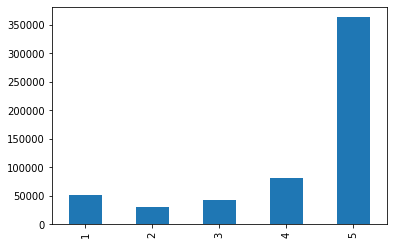

In [46]:
data['Score'].value_counts(dropna=False).sort_index().plot(kind='bar')

There is clearly an 5 stars scores domination within given data. 

# Data pre-processing
I want to predict the number of stars based on the content of the review.

In [0]:
X = data['Text']
y = data['Score']

words = 10000
maxlen = 200

# initiailize tokenizer
token = Tokenizer(num_words=words)
token.fit_on_texts(X)

# prepare y for softmax function
y = to_categorical(y-1)

# split train, valid and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# tokenize words
X_train_seq = token.texts_to_sequences(X_train)
X_valid_seq = token.texts_to_sequences(X_valid)
X_test_seq = token.texts_to_sequences(X_test)

X_train_seq_padded = pad_sequences(X_train_seq, maxlen=maxlen)
X_val_seq_padded  = pad_sequences(X_valid_seq, maxlen=maxlen)
X_test_seq_padded  = pad_sequences(X_test_seq, maxlen=maxlen)

In [49]:
# Analyze lenghts of the sequencees
train_a = [len(i) for i in X_train_seq]
print('Minimum lenght: ', min(train_a))
print('Maximum lenght: ', max(train_a))
print('Mean lenghts: ', np.mean(train_a))
print('Median lenghts: ', np.median(train_a))

Minimum lenght:  0
Maximum lenght:  3292
Mean lenghts:  79.95744720953464
Median lenghts:  56.0


The text with 3292 words seems to be an outlier.

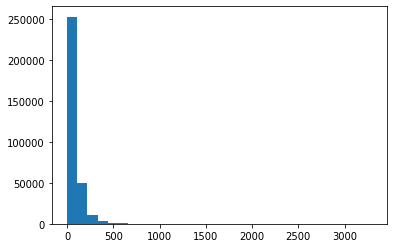

In [50]:
plt.hist(train_a, bins=30)
plt.show()

In [51]:
# How many categories
y.shape

(568454, 5)

# Tunning the model


In [0]:
def create_model(number_layer, number_lstm, number_dense, number_embedding, dropout_rate, learning_rate, max_text_len=800):
  model = Sequential()
  model.add(Embedding(words, number_embedding, input_length=max_text_len))
  model.add(SpatialDropout1D(0.2))
  for n in range(1,number_layer+1):
    if n != number_layer:
      model.add(LSTM(units=number_lstm, dropout=0.3, return_sequences=True))
    else:  
      model.add(LSTM(units=number_lstm, dropout=0.3))
  model.add(Dense(number_dense, activation="relu"))
  model.add(Dropout(dropout_rate))
  model.add(Dense(5, activation="softmax"))
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["acc"])
  return model

In [53]:
np.array(X_train_seq_padded).shape

(318334, 200)

In [0]:
# Define parameters
params = {
    'number_layer': [1],
    'number_lstm': [32, 64],
    'number_dense': [100, 1000],
    'number_embedding': [5, 32],
    'dropout_rate': [0.4],
    'learning_rate': [0.01],
    'max_text_len': [maxlen]
}

In [0]:
model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=100, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=params, cv=3, verbose=1)
grid_result = grid.fit(X_train_seq_padded, y_train)

In [0]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Train model on given parameters

In [0]:
# define model
model = create_model(1,64,1000,32,0.4,0.01,maxlen)

# define callbacks
Checkpoint = ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/Stars_prediction/model_checkpoint.h5", monitor='val_loss', verbose=1, save_best_only=True)
Early_Stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# fit the model
history = model.fit(X_train_seq_padded, np.array(y_train), batch_size=300, epochs=100, 
          validation_data=(X_val_seq_padded, y_valid), callbacks=[Checkpoint,Early_Stopping])

# save created model
model.save_weights("/content/drive/My Drive/Colab Notebooks/Stars_prediction/model.h5")

Epoch 1/100
1062/1062 [==============================] - ETA: 0s - loss: 0.7999 - acc: 0.7064
Epoch 00001: val_loss improved from inf to 0.69205, saving model to /content/drive/My Drive/Colab Notebooks/Stars_prediction/model_checkpoint.h5
1062/1062 [==============================] - 60s 57ms/step - loss: 0.7999 - acc: 0.7064 - val_loss: 0.6921 - val_acc: 0.7395
Epoch 2/100
1061/1062 [============================>.] - ETA: 0s - loss: 0.6724 - acc: 0.7470
Epoch 00002: val_loss improved from 0.69205 to 0.63510, saving model to /content/drive/My Drive/Colab Notebooks/Stars_prediction/model_checkpoint.h5
1062/1062 [==============================] - 63s 60ms/step - loss: 0.6723 - acc: 0.7471 - val_loss: 0.6351 - val_acc: 0.7599
Epoch 3/100
1061/1062 [============================>.] - ETA: 0s - loss: 0.6412 - acc: 0.7581
Epoch 00003: val_loss improved from 0.63510 to 0.61839, saving model to /content/drive/My Drive/Colab Notebooks/Stars_prediction/model_checkpoint.h5
1062/1062 [==============

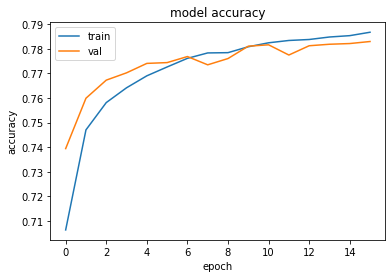

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [55]:
model = create_model(1,64,1000,32,0.4,0.01,maxlen)
model.load_weights("/content/drive/My Drive/Colab Notebooks/Stars_prediction/model.h5")
pred = model.predict(X_test_seq_padded, 100, verbose=1)

1137/1137 [==============================] - 16s 14ms/step


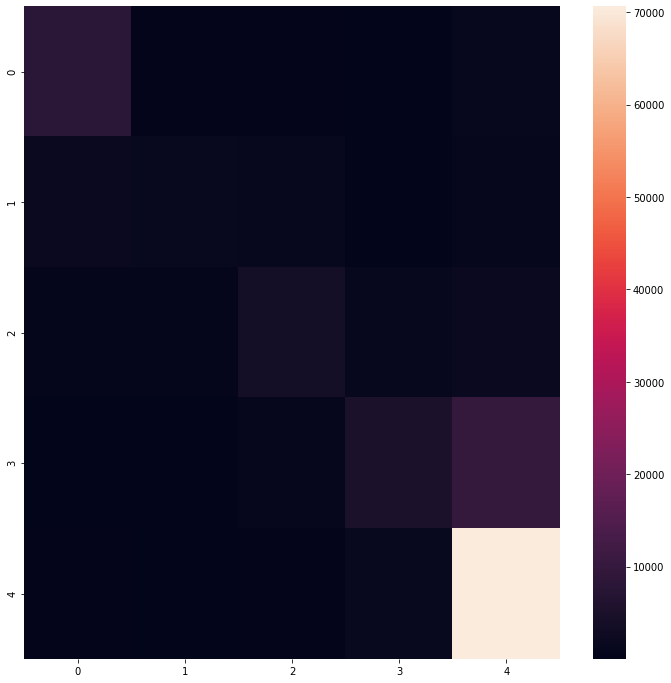

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = np.argmax(y_test, axis = 1).tolist()
y_pred = np.argmax(pred, axis = 1).tolist()
matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(matrix,cbar=True)
plt.show()

In [75]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73     10326
           1       0.56      0.27      0.37      5855
           2       0.54      0.44      0.48      8485
           3       0.63      0.32      0.43     16123
           4       0.83      0.97      0.90     72902

    accuracy                           0.78    113691
   macro avg       0.65      0.55      0.58    113691
weighted avg       0.76      0.78      0.76    113691



Given model returns quite good results. The main problem of created model is that it is more likely to predict the 5 stars then any other class. The 5 star rewievs are predicted with 97% of recall and 1 star reviews are predicted with 76% of recall. But for 2,3,4 stars predictions there is a problem becuse we were lacking data in this categories. 